# HW3: Part 2 - GPUs

v1.0 (2021 Spring): Aled Cuda, Aditya Sengupta

**Time Budget: 3 Hours**

Imagine you took a really wide SIMD unit, bolted it onto a really minimal processor, crammed a bunch of them onto one chip, and then burried it under several hundred layers of abstraction and NDAs. For some reason, we call this device a GPU which stands for "Graphics Processing Unit".

**NOTE: Unless you are willing and able to do a SIGNIFICANT amount of setup on your computer and happen to have a Nvidia GPU lying around, you MUST run this notebook on the [course server](http://jupyter.ld-cd.net). Simply enter your preferred/first name as the login, and enter whatever password you would like.**

## Computation Model
*(Note: Most of the things in this section are NVIDIA specific, but other architectures are pretty similar)*

The computation model for GPUs is really confusing, but it makes  a little more sense if you understand how the GPUs are put together:

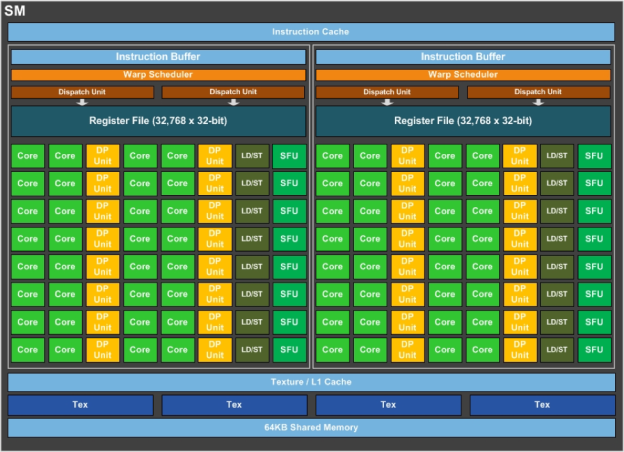

The diagram shown here is a high level overview of a single "Stream Module". The stream module consists of a relatively simple processor that interprets your program and manually schedules the execution of incredibly simple instructions inside each of the blocks labelled "Core" which are essentially very simple floating-point arithmetic logic units. These cores share a single set of registers (well, there are two banks technically) and are packed together with a few double precision cores, load/store cores, and "Special Function Units" which compute things like sin, cos, sqrt, and so on.

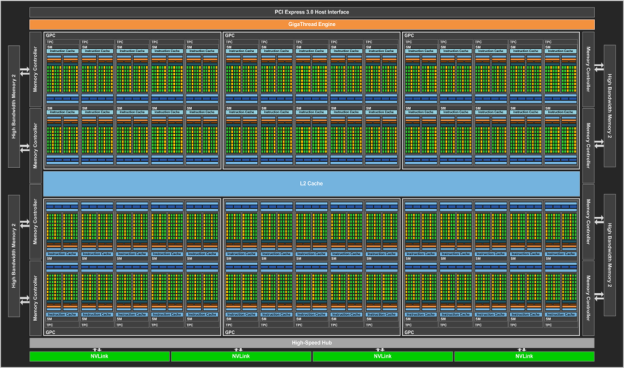

The entire GPU consists of a few dozen to a few hundred Stream Modules grouped together onto a single die along with blocks for interfacing with memory and driving a display. There's also a couple general purpose CPUs that pull the strings to make the whole thing dance.

Programs for NVIDIA GPUs are typically called kernels. The code that you write in a kernel will typically be code required to produce a single element of the output, a lot like Numba's vectorize operator. This code can then be spawned on thousands of times, once for each output element. Threads are spawned in blocks of typically between 64 and 1024 threads (usually in powers of 2). A Stream Module is then assigned to each block and each thread can query which block it is in, and which thread it is in in that block. If your output is a 1D array, then the position of a thread in the output is given by `blockid*BLOCKSIZE + threadinblock`. Fortunately, Numba includes a shorthand for this in the form of `cuda.grid(1)` which returns your position in all the threads. Because you instantiate kernels with an integer number of blocks, if your output is not a multiple of the size of the block, then there will be several threads spawned without a corresponding element in the result. To manage this you usually want to have a condition in your code so that only threads that operate on an output element run anything. This is pretty confusing, and best expressed by example:

```python
from numba import cuda

@cuda.jit
def square_cuda(x):
    """
    The actual CUDA kernel which gets called on every thread
    """
    # Retrieve theis threads position in the (in this case 1D) "grid" of all threads of this kernel
    pos = cuda.grid(1)
    if pos < x.size:
        # In this case we overwite the original values
        x[pos] = x[pos]*x[pos]

def square_wrap(x, blocksize = 128):
    """
    Wrap the CUDA kernel with some code to launch it
    """
    # Compute the smallest number of blocks required to launch enough threads to handle every element
    blocks = (x.size + blocksize - 1) // blocksize
    # Launch `blocks` blocks of this kernel, each with blocksize threads
    square_cuda[blocks, blocksize](x)

# The GPU we are working with has best performance with 32 bit floats by an order of magnitude
square_wrap(np.float32(np.arange(2**18)))
```

This example builds a simple kernel which replaces every element in an array by its square. This kernel is then launched on each of the threads. With a blocksize of 128 we have `2**18/128 = 2048` blocks which the stream modules will work their way through. In this case, the array size was a multiple of the element size so we had no unused threads. However, if we had `2**18 + 1` elements in our array we would have launched 2049 blocks, and only one of the threads in the extra block would run anything, with the condition failing for the rest of them.

## Memory Model

In most of the programming we have done so far, all memory is essentially equal. There might be multiple levels of cache with different properties, but it's all essentially completely transparent. We may be able to observe its effects, but we don't (and indeed can't) manipulate it directly. When you attach any type of accelerator to a computer, things unfortunatly get quite a bit more complicated.

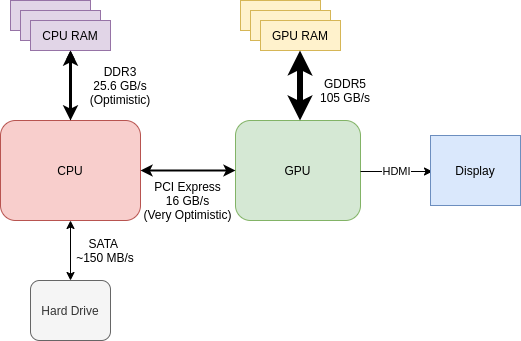

The image above is a fairly high level overview of all the systems on the computer the notebook is presumably running on. Up to now, all of our computation has occured on the CPU and operated on data in the RAM attached to the CPU. Now that we're dealing with the GPU we can choose to place our computations there or on the CPU. Further, we can choose to keep our data stored in the RAM of either one. The majority of the work in extracting performance out of a GPU in real world workloads is often going to happen around shipping data in and out of the GPU. On the diagram above, the widths of each leg represent the total bandwith each connection has available to it.

The CPU's memory has the lowest latency of any link in the computer, but on this old system, it's fairly bandwith constrained. The GPU's memory, on the other hand, has about 4 times the bandwith, but it trades this off for noticeably more latency, and in this case, less total memory. This means that the GPU is REALLY good at operations on lots of data which are simple enough for the GPU to be able to predict what parts of memory you will need before you access them, so that it can fetch them early so you don't notice the extra latency on the other hand. The CPU, on the other hand, is better at performing strange operations on small to medium sized pieces of data. In other words, if you were writing a web server, you probably want to use the CPU. If you're taking a Fourier transform of radio data, that's an excellent task for the GPU.

In between the GPU and the CPU is a PCI Express link, which is what your computer uses for attaching network cards, fast Solid-State Disks, and accelerators like GPUs. This link has relatively low bandwith and relatively high latency compared to the memory buses, which means we want to avoid shipping data between the CPU and GPU as much as possible. Generally you'll want to ship it there once, do all the processing you can, and then ship only the result you need back.

This is why you attach your screen to your GPU instead of to your motherboard. When you start a program, you can just load the GPU up with all the images and 3D models it will need. The GPU can just punt along, generating every frame in its own memory and shipping them out to the display. This doesn't require any traffic over the PCIe bus other than commands to move objects around in a scene. It was a lucky coincidence that this architecture, originally designed for 3D graphics, fits the computational model we want for scientific computing so well.

Although Numba's CUDA interface lets the CPU transparently operate on data in the GPU and vice versa, in actuality to make this happen Numba has to ship the data back and forth. This is an easy mistake to make, and is probably what is happening if you notice your code suddenly taking a lot more time.

Numba provides a couple simple functions to manage all this that are much easier to show than tell:

```python
import numpy as np
from numba import cuda

# Create an array in the cpu's memory using numpy like normal
cpuarr = np.linspace(0, 1000, 10000, dtype=np.float32)

# Copy the contents of that array into a new array in the GPU's memory, moving the data over the PCIe link
gpuarr = cuda.to_device(cpuarr)

# Create a new array on the GPU which is empty (contains unspecified junk data) with the same size as the input to store our result (note cpuarr and gpuarr are interchangeable, we are just using them to get size information)
gpures = cuda.device_array(cpuarr.size)
# Or my preferred way:
gpures = cuda.device_array_like(cpuarr)

# Perform a computation
some_gpu_func(gpuarr, gpures)

# Copy our result back to a numpy array on the host
cpures = gpures.to_host()
```

There are a number of other potentially handy memory management functions which are (nonexhaustively) listed [here](https://numba.pydata.org/numba-doc/latest/cuda/memory.html).

In addition to what we discussed here, the GPU also has an additional class of memory which we won't really be touching on in this class but is handy to know about. This is ["shared memory"](https://developer.nvidia.com/blog/using-shared-memory-cuda-cc/). What NVIDIA calls Shared Memory is a small amount of memory in each Stream Module that is shared between all the threads in the block running on said SM, which is much faster than the off chip memory. This is really handy for algorithims like matrix multiplication where you can decompose the problem into many smaller problems. By using shared memory, each thread block can perform a small matrix multiplication much more quickly than using main memory, and then these results can be quickly aggregated to produce a final result. At its essence the so-called "Shared Memory" is essentially an explicitly managed cache. In fact, physically, the cache and shared memory are just a single piece of memory that's been partitioned into two.

### Question 1:

Run the cell below, and note the execution time on both the CPU and the GPU. Explain why the GPU execution time is so much worse than the CPU execution time.

**Your Answer**

In [ ]:
from numba import cuda
import numpy as np

@cuda.jit
def square_cuda(x):
    """
    The actual CUDA kernel which gets called on every thread
    """
    # Retrieve theis threads position in the (in this case 1D) "grid" of all threads of this kernel
    pos = cuda.grid(1)
    if pos < x.size:
        # In this case we overwite the original values
        x[pos] = x[pos]*x[pos]

def square_wrap(x, blocksize = 128):
    """
    Wrap the CUDA kernel with some code to launch it
    """
    # Compute the smallest number of blocks required to launch enough threads to handle every element
    blocks = (x.size + blocksize - 1) // blocksize
    # Launch `blocks` blocks of this kernel, each with blocksize threads
    square_cuda[blocks, blocksize](x)

data = np.linspace(0, 10, int(1e6), dtype=np.float32)

print("GPU execution time")
%timeit _ = square_wrap(data)
print("CPU execution time")
%timeit data*data

### Question 2:

Alter how the code is invoked using what you know about memory management, so that you reduce the GPU execution time to below the CPU time.

*(Note: This may seem like a bit of a synthetic result: after all, we just move part of the process out of the timeit, but this is just a stepping stone. As we will see in the next question we can generate a lot of things, like linspaces, on the device itself without involving the CPU or its memory)*

In [ ]:
# you need to add a line up here

print("New GPU execution time")
%timeit _ = square_wrap(_) # What goes here
print("CPU execution time")
%timeit data*data

### Question 3:

Fill out the cell below to create a linspace function on the GPU. Your code should exist in two parts: a cuda kernel which takes an empty array and fills each element i according to the function `arr[i] = start + i * (stop-start)/num`, and a wrapper function which allocates an empty array on the device and invokes the kernel to fill it. This is equivalent to numpy's linspace function in `endpoint=False` mode.

In [ ]:
# Note: The naive way of doing this is still pretty fast, but if you realize that this is basically y = m*x + b
#       and compute the slope a single time outside of the kernel, you can make it run even faster

@cuda.jit
def linspace_kernel(arr, start, stop, num):
    # Find our position in the array
    pos = cuda.grid(1)
    # Your code here:

def linspace_wrap(start, stop, num, blocksize = 128):
    # Compute the smallest number of blocks required to launch enough threads to handle every element
    blocks = (num + blocksize - 1) // blocksize
    
    # Create a block of memory to store your result:
    arr = _
    # Invoke your kernel:
    
    # Return a result:
    return arr

gpu_l = linspace_wrap(0, 100, int(1e6))
cpu_l = np.linspace(0, 100, int(1e6), endpoint=False, dtype=np.float32)
assert np.allclose(gpu_l, cpu_l)

print('GPU Linspace Performance:')
%timeit linspace_wrap(0, 100, int(1e6))
print('CPU Linspace Performance:')
%timeit np.linspace(0, 100, int(1e6), endpoint=False, dtype=np.float32)

### Question 4:

Play with the `num` parameter. Try generating an array with a few dozen elements and a few million (but don't go over 2-3 million; this GPU is shared between this whole class, and it doesn't have a lot of memory). Note how the performance changes. Make a quick plot with 5 or 6 points of its performance, and speculate on the cause of any non-linearities you observe.

You may want to use the Python `time` library instead of the IPython `%timeit` line magic, so that you don't have to manually write down the data you want to plot. The `time.time()` function returns the number of seconds (with a fractional component) since a reference time (usually 1 January 1970 at midnight UTC - run `time.gmtime(0)` to see when it is) - think about how you can use this to time individual operations!

In [ ]:
import time
time.time() # run me a few times to see

In [ ]:
import matplotlib.pyplot as plt

# You don't need anything fancy here, just make a relatively simple plot with a couple points

**YOUR ANSWER**

### Question 5:

Decrease the blocksize parameter to 4 (try to only use powers of 2), then increase it to 1024 (the max supported). Note how decreasing the blocksize at a certain point starts to decrease performance, but increasing it past a point doesn't do anything. Speculate on the cause of this effect.

**YOUR ANSWER**

A lot of problems, like the monte-carlo pi estimation problem for example, fit into a class of problems called map-reduce problems; you have a large set of data which you perform a mapping on, and then you perform a reduction step to distill that data down into a single, smaller, answer. So far, everything we have done here is just the mapping step. 

Note that the idea of reduction is also expressed in the Python `functools.reduce` function, which repeatedly applies a function to an iterable (a list, a `range` object, etc.) and returns the end result. `map` is also built into Python, which makes it easy to express problems in a map-reduce format:

In [ ]:
from functools import reduce

print("Sum of ints 0-9:           ", reduce(lambda a, b: a + b, range(10)))
print("Sum of squares of ints 0-9:", reduce(lambda a, b: a + b, map(lambda x: x ** 2, range(10))))

Writing reductions on the GPU can be difficult, but fortunately numba provides a decorator that lets us express simple reductions of two variables. Run the cell below to see how this works.

In [ ]:
@cuda.reduce
def sum_cuda(a, b):
    return a + b

a = linspace_wrap(0, 1, 10000)
sum_gpu = sum_cuda(a)
sum_cpu = np.sum(np.linspace(0, 1, 10000, endpoint=False))

print("GPU Sum = {}, CPU Sum = {}".format(sum_gpu, sum_cpu))

### Question 6:

This question is pretty open ended because generating random numbers on the GPU is actually pretty complicated. Each thread needs to have a seperate random number generator with seperately intialized seeds and state. Generally speaking, random number generators on GPUs should always be treated with a degree of caution. They're designed for AI and Graphics applications, and they work well enough for that, but they don't always have sufficient entropy for real scientific applications.

Look at the Numba documentation page for random number generation [here](https://numba.pydata.org/numba-doc/latest/cuda/random.html). Read through it to get a general idea of how Numba's random number generator works. Modify their example to use the sum reduction function we defined above. Play with the number of blocks, iterations, and threads per block and see where your best performance region is. Are there any values you can precompute on the CPU? Is any part of the reduction step more efficently preformed on the CPU at the end?

Hint: you don't necessarily have to change the `compute_pi` function. Think about what else could be made more efficient!

In [ ]:
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32